# Time Series Segmentation through Automatic Feature Learning


In [1]:
from nptdms import TdmsFile
from sklearn import preprocessing 
import pandas as pd
import numpy as np
#from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seglearn as sgl
from matplotlib.mlab import PCA


**explain** We now consider the situation where we have a number of time series and  wish toexplore the relations between them. We rst look at the relation between crosscorrelation and multivariate autoregressive models and then at the cross-spectral density and coherence.


In [2]:
# load in data
tdms_file = TdmsFile(".\\FW-1-1\\AKF-FW1-1-H1021-1500.tdms")
#list out the groups
groups = tdms_file.groups()  
df = tdms_file.object('DINT').as_dataframe()

#tdms_file2 = TdmsFile(".\\FW-1-1\\AKF-FW1-1-H521-1000.tdms")
#df2 = tdms_file2.object('DINT').as_dataframe()
#tdms_file3 = TdmsFile(".\\FW-1-1\\AKF-FW1-1-H862-1000.tdms")
#df3 = tdms_file3.object('DINT').as_dataframe()

**Explain**:  the following 3 Graphs demonstrate the normal working state and abnormal state.

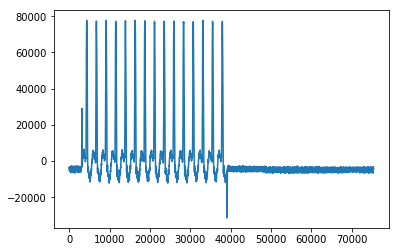

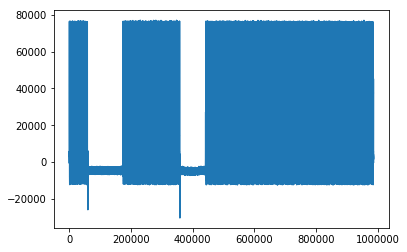

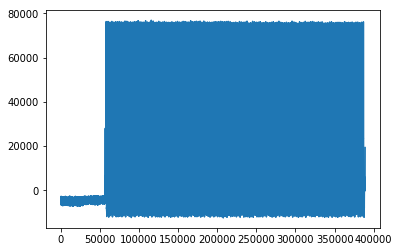

In [47]:
df_power = df['SupplyUnit 50U4 (Unidrive M701 Regen).Transmit PDO Mapping 8.Leistung']
df_power.plot()
plt.show()
# df_power2, df_power3 they are quit similar


In [5]:
'''
Important step is to segmentation the time series data
we use the sliding window method
'''
def SW_seg(df_power):
    # sliding window method
    df_seg = []
    size_df = df_power.size
    anchor = 1 
    width = 965
    while((anchor+width*3) < size_df): 
        mid = df_power[anchor+width: anchor+width*3].idxmax()
        seg = df_power[mid-width: mid+width]
        #if (max(seg)<10):
           #continue
        df_seg.append(seg.values)
        anchor = mid
    return df_seg

#df_seg= df_seg[30:]

In [6]:
df_power = df['SupplyUnit 50U4 (Unidrive M701 Regen).Transmit PDO Mapping 8.Leistung']
df_seg = SW_seg(df_power)

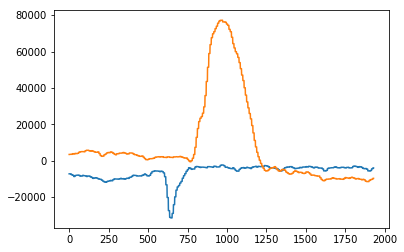

In [36]:
plt.plot(df_seg[16])
plt.plot(df_seg[14])

In [70]:
from sklearn.decomposition import PCA

x = np.array(df_seg)
pca = PCA(n_components=400).fit(x)
# inconsistencies in array construction from a list of ndarrays
df_seg2 = pca.transform(x)

In [6]:
import random

def DTWDistance(s1, s2,w):
    DTW={}
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
            
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

def k_means_clust(data,num_clust,num_iter,w=5):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print(counter)
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5) < min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist < min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=[]
            mn = len(assignments[key])
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/mn for m in clust_sum]
            
    return centroids

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(df_seg)
kmeans.labels_

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
'''
The following the data is to predict and detect the anormaly data
'''
tdms_file2 = TdmsFile(".\\FW-1-1\\AKF-FW1-1-H2366-2500_neues Coil.tdms")
df2 = tdms_file2.object('DINT').as_dataframe()
test = SW_seg(df2['SupplyUnit 50U4 (Unidrive M701 Regen).Transmit PDO Mapping 8.Leistung'])
predict = kmeans.predict(test)
print(predit)

In [10]:
predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])